In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
from Data_Loader import *
from Generator import *
from Discriminator import *

In [3]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 15
dim_A = 3
dim_B = 3
display_step = 300
batch_size = 1
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [5]:
class CycleGan:
  def __init__(self, dim_A, dim_B,emotion):
    self.gen_AB = Generator(dim_A, dim_B).to(device)
    self.gen_BA = Generator(dim_B, dim_A).to(device)
    self.gen_opt = torch.optim.Adam(list(self.gen_AB.parameters()) + list(self.gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
    self.disc_A = Discriminator(dim_A).to(device)
    self.disc_A_opt = torch.optim.Adam(self.disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
    self.disc_B = Discriminator(dim_B).to(device)
    self.disc_B_opt = torch.optim.Adam(self.disc_B.parameters(), lr=lr, betas=(0.5, 0.999))
    self.emotion = emotion

  def weights_init(self, m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

  def load_model(self, path):
    pre_dict = torch.load(path)
    self.gen_AB.load_state_dict(pre_dict['gen_AB'])
    self.gen_BA.load_state_dict(pre_dict['gen_BA'])
    self.gen_opt.load_state_dict(pre_dict['gen_opt'])
    self.disc_A.load_state_dict(pre_dict['disc_A'])
    self.disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    self.disc_B.load_state_dict(pre_dict['disc_B'])
    self.disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])

  def weight_initialization(self):
    self.gen_AB = self.gen_AB.apply(self.weights_init)
    self.gen_BA = self.gen_BA.apply(self.weights_init)
    self.disc_A = self.disc_A.apply(self.weights_init)
    self.disc_B = self.disc_B.apply(self.weights_init)

  def save_model(self,path,cur_step):
    em = self.emotion
    torch.save({
                        'gen_AB': self.gen_AB.state_dict(),
                        'gen_BA': self.gen_BA.state_dict(),
                        'gen_opt': self.gen_opt.state_dict(),
                        'disc_A': self.disc_A.state_dict(),
                        'disc_A_opt': self.disc_A_opt.state_dict(),
                        'disc_B': self.disc_B.state_dict(),
                        'disc_B_opt': self.disc_B_opt.state_dict()
      }, f"{path}/{em}/Step_{cur_step}.pth")

  def set_dataset(self,dataset):
    self.target_dataset = FilteredDataset(dataset,self.emotion)
    

In [6]:
def get_identity_loss(real_X, gen_YX, identity_criterion):

    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(real_X, identity_X)
    return identity_loss, identity_X

In [7]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):

    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(real_X, cycle_X)

    return cycle_loss, cycle_X

In [8]:
classifier = models.resnet50(weights=False)  # Example: ResNet-18, change as needed
num_features = classifier.fc.in_features     #extract fc layers features
classifier.fc = nn.Linear(num_features, 6)
classifier = classifier.to(device)
# Step 2: Define the path to the pre-trained weights file (if available)
pretrained_weights_path = 'data/SER_Teess_Savee_Ravdess_classifier.pth'  # Replace with your actual path
classifier.load_state_dict(torch.load(pretrained_weights_path))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [9]:
classifier.fc = torch.nn.Identity()

In [10]:
import scipy
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [11]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    return torch.norm(mu_x-mu_y)*torch.norm(mu_x-mu_y)+ torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))

In [12]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(224, 224), mode='bilinear')
    return img

In [13]:
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().cpu().numpy(), rowvar=False))

In [14]:
def Fid_plot(fid_arr,class_target):
  x = [i * display_step for i in  range(len(fid_arr))]
  plt.figure(figsize=(8,6))
  plt.plot(x, fid_arr)
  plt.title(f'Fid score for {class_target} class')
  plt.xlabel('Steps')
  plt.ylabel('Fid')
  plt.show()

In [15]:
import numpy as np
plt.rcParams["figure.figsize"] = (6, 6)


def train(Emotion_gan,save_model=True):
    Fid_scores = []
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    Emotion_gan.set_dataset(dataset)
    print(Emotion_gan.target_dataset[0][1])
    source_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    target_loader = DataLoader(Emotion_gan.target_dataset, batch_size=batch_size, shuffle=True)
    
    cur_step = 0

    for epoch in range(n_epochs):
        fake_features_list = []
        real_features_list = []

        for real_A, real_B in zip(source_loader,target_loader):
            #print(real_A[0].shape, real_B[0].shape)
            #Real B --> Fake B:Target
            real_A = real_A[0]
            real_B = real_B[0]

            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            Emotion_gan.disc_A_opt.zero_grad()
            with torch.no_grad():
                fake_A = Emotion_gan.gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, Emotion_gan.disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)
            Emotion_gan.disc_A_opt.step()

            Emotion_gan.disc_B_opt.zero_grad()
            with torch.no_grad():
                fake_B = Emotion_gan.gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, Emotion_gan.disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True)
            Emotion_gan.disc_B_opt.step()

            Emotion_gan.gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, Emotion_gan.gen_AB, Emotion_gan.gen_BA, Emotion_gan.disc_A, Emotion_gan.disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()
            Emotion_gan.gen_opt.step()

            mean_discriminator_loss += disc_A_loss.item() / display_step
            mean_generator_loss += gen_loss.item() / display_step

            #FID
            with torch.no_grad():
                Resnet_real_B = preprocess(real_B)
                real_features = classifier(Resnet_real_B)
                real_features_list.append(real_features)

                Resnet_fake_B = preprocess(fake_B)
                fake_features = classifier(Resnet_fake_B)
                fake_features_list.append(fake_features)

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                #show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape[0], target_shape[1]))
                show_tensor_images(torch.cat([real_B, fake_B]), size=(dim_B, target_shape[0], target_shape[1]),step=cur_step,target=Emotion_gan.emotion)
                save_tensor_image(fake_B,cur_step,Emotion_gan.emotion)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                if save_model:
                    Emotion_gan.save_model('Gan_Results/Models/',cur_step)
            cur_step += 1
        fake_features_all = torch.cat(fake_features_list)
        real_features_all = torch.cat(real_features_list)
        mu_fake = torch.mean(fake_features_all,0)
        mu_real = torch.mean(real_features_all,0)
        if fake_features_all.shape[0] == 1:
            fake_features_all = fake_features_all.repeat(2, 1)
        if real_features_all.shape[0] == 1:
            real_features_all = real_features_all.repeat(2, 1)
        sigma_fake = get_covariance(fake_features_all)
        sigma_real = get_covariance(real_features_all)
        with torch.no_grad():
            print(mu_real.shape, mu_fake.shape, sigma_real.shape, sigma_fake.shape)
            cur_fid = frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item()
            print('FID Score is: ',cur_fid)
            Fid_scores.append(cur_fid)
    return Fid_scores


1
Epoch 0: Step 0: Generator (U-Net) loss: 0.09118344306945801, Discriminator loss: 0.002721593677997589


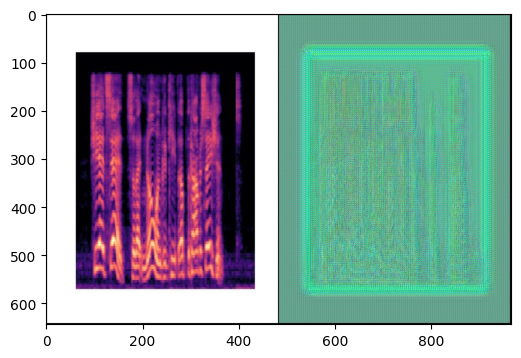

FID Score is:  532.5604858398438
Epoch 1: Step 200: Generator (U-Net) loss: 2.3608485960960386, Discriminator loss: 0.2324502687156201


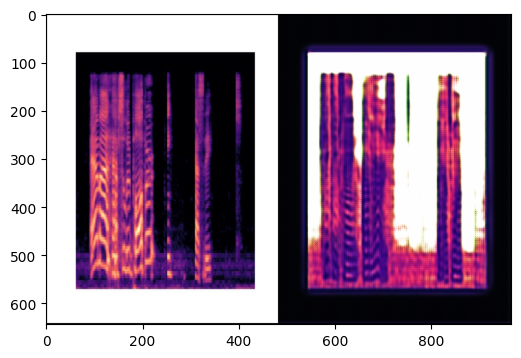

FID Score is:  288.27874755859375
Epoch 2: Step 400: Generator (U-Net) loss: 1.5692117840051647, Discriminator loss: 0.2311129467934371


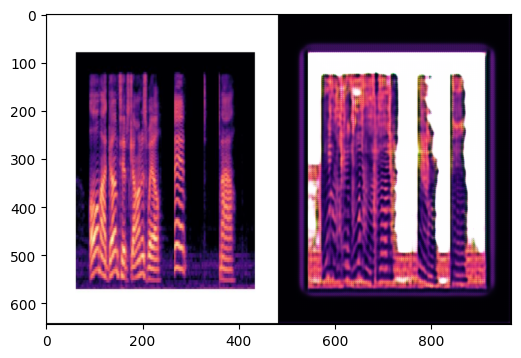

FID Score is:  263.9315185546875
FID Score is:  225.2479248046875
Epoch 4: Step 600: Generator (U-Net) loss: 2.4209763962030393, Discriminator loss: 0.24226287752389902


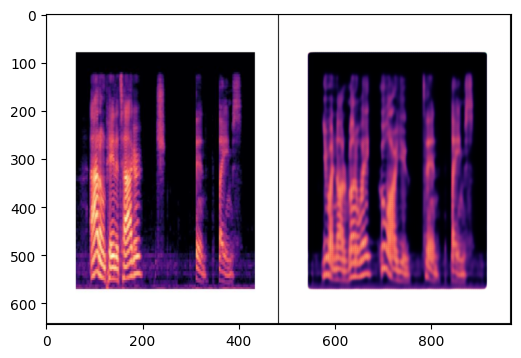

FID Score is:  146.03970336914062
Epoch 5: Step 800: Generator (U-Net) loss: 1.3616001993417743, Discriminator loss: 0.250640620738268


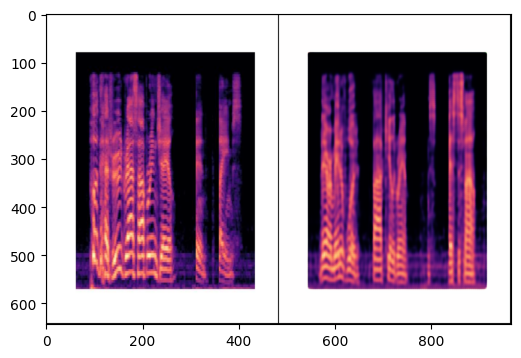

FID Score is:  121.5792465209961
FID Score is:  113.53042602539062
Epoch 7: Step 1000: Generator (U-Net) loss: 1.2297260838747022, Discriminator loss: 0.25088396839797505


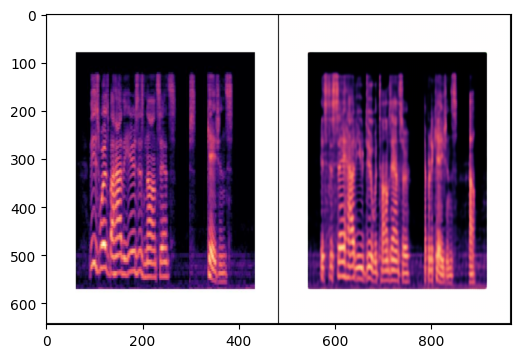

FID Score is:  105.75482177734375
Epoch 8: Step 1200: Generator (U-Net) loss: 1.1420976331830035, Discriminator loss: 0.2507735615968704


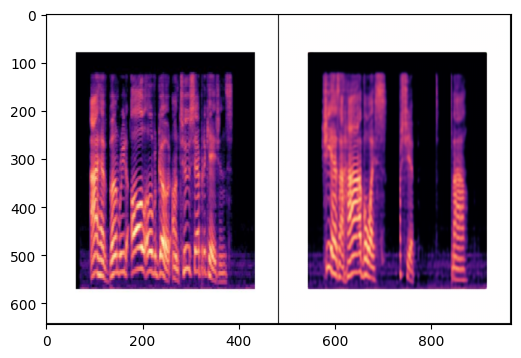

FID Score is:  101.91580200195312
FID Score is:  97.02153015136719
Epoch 10: Step 1400: Generator (U-Net) loss: 1.0904007205367094, Discriminator loss: 0.2507886660099031


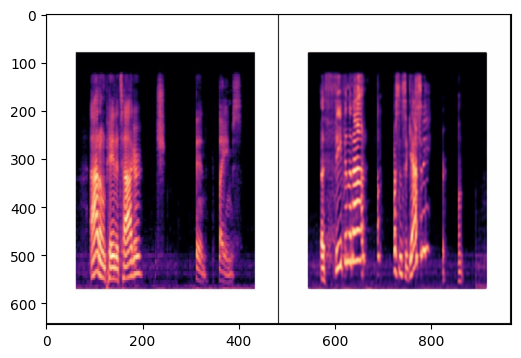

FID Score is:  101.35749816894531
Epoch 11: Step 1600: Generator (U-Net) loss: 1.0438984185457234, Discriminator loss: 0.2504244323819875


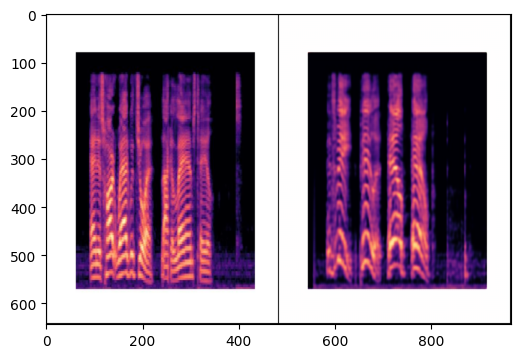

FID Score is:  96.99392700195312
Epoch 12: Step 1800: Generator (U-Net) loss: 1.0128600078821175, Discriminator loss: 0.2502055564522744


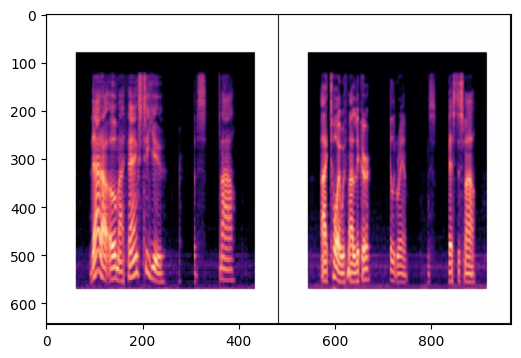

FID Score is:  96.15813446044922
FID Score is:  92.3700942993164
Epoch 14: Step 2000: Generator (U-Net) loss: 0.9893315568566323, Discriminator loss: 0.24978940166532984


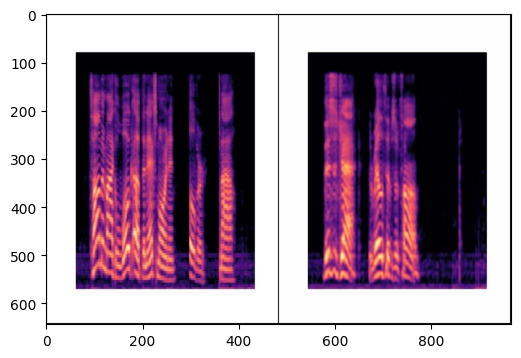

FID Score is:  92.4786148071289
Epoch 15: Step 2200: Generator (U-Net) loss: 0.9605693009495733, Discriminator loss: 0.24868905447423448


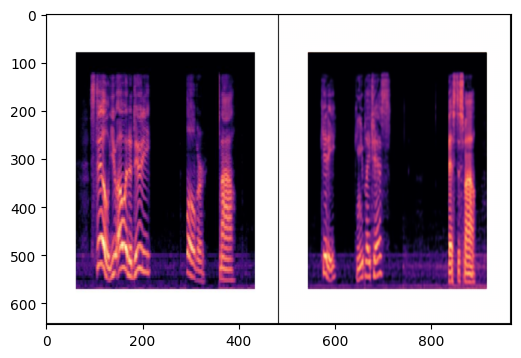

FID Score is:  92.89190673828125
FID Score is:  95.9648666381836
Epoch 17: Step 2400: Generator (U-Net) loss: 0.9533622449636461, Discriminator loss: 0.24781659401953227


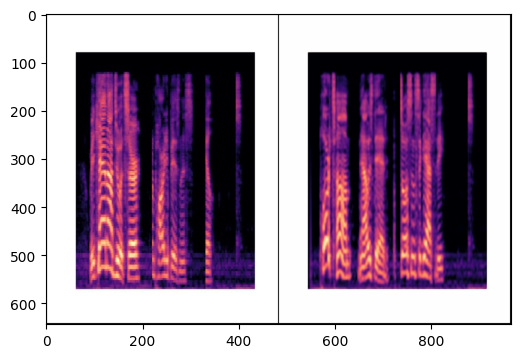

FID Score is:  94.61441040039062
Epoch 18: Step 2600: Generator (U-Net) loss: 0.9397274366021154, Discriminator loss: 0.24757501922547823


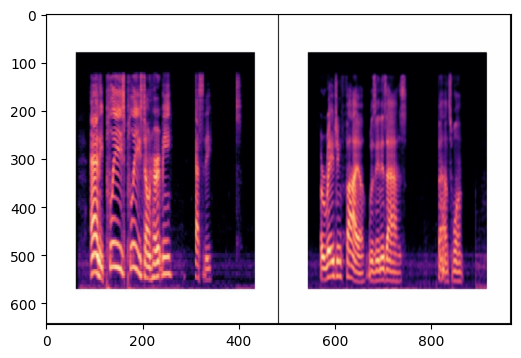

FID Score is:  94.29302978515625
FID Score is:  95.37226104736328
Epoch 20: Step 2800: Generator (U-Net) loss: 0.932488969564438, Discriminator loss: 0.249049300402403


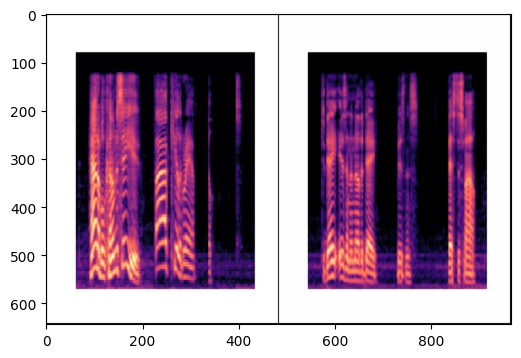

FID Score is:  83.11119842529297
Epoch 21: Step 3000: Generator (U-Net) loss: 0.9262187463045121, Discriminator loss: 0.24874175727367404


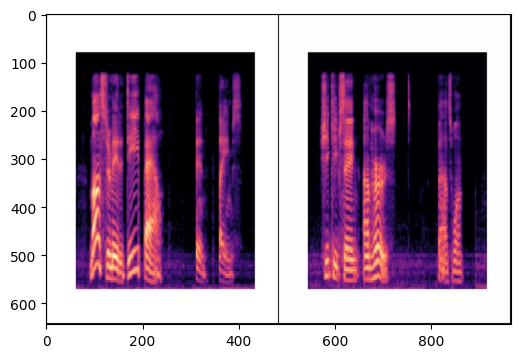

FID Score is:  84.1629867553711
Epoch 22: Step 3200: Generator (U-Net) loss: 0.9078645977377887, Discriminator loss: 0.24893293835222718


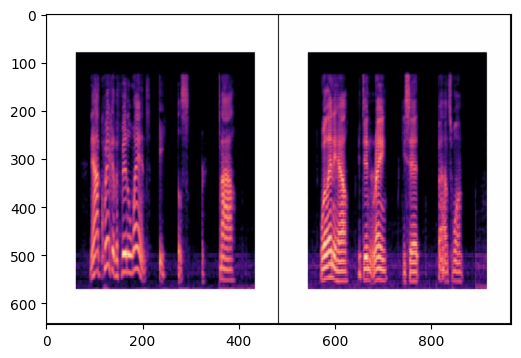

FID Score is:  82.4338150024414
FID Score is:  73.8361587524414
Epoch 24: Step 3400: Generator (U-Net) loss: 0.8888001650571824, Discriminator loss: 0.24870034843683217


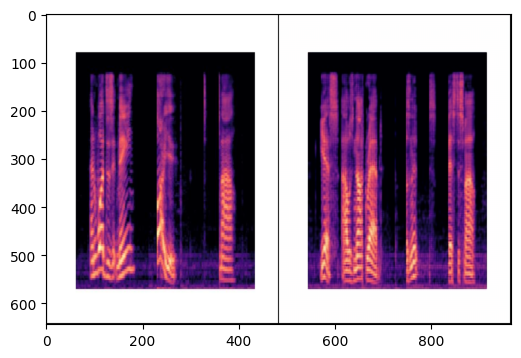

FID Score is:  75.58332824707031


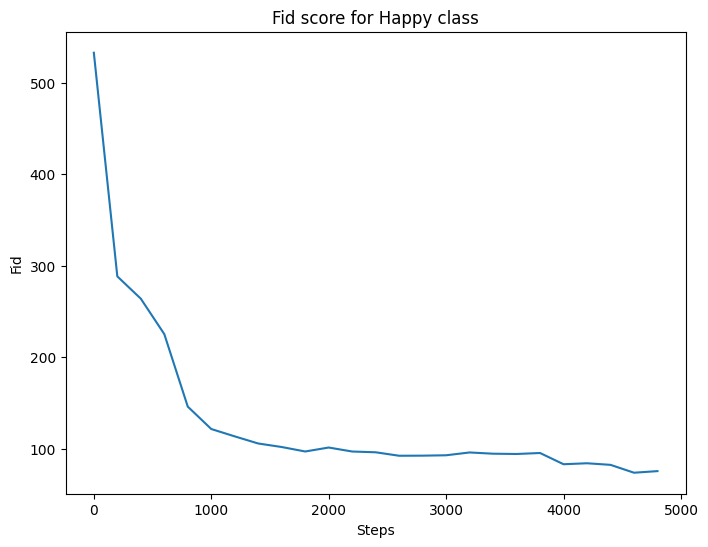

In [16]:
Happy_Gan = CycleGan(3,3,'Happy')
Happy_Fid = train(Happy_Gan)
Fid_plot(Happy_Fid,'Happy')

In [29]:
Happy_Gan.save_model('Gan_Results/Models',4500)

In [33]:
!ls Gan_Results/Models/Happy

3
Epoch 0: Step 0: Generator (U-Net) loss: 0.061577281951904296, Discriminator loss: 0.0014382887880007426


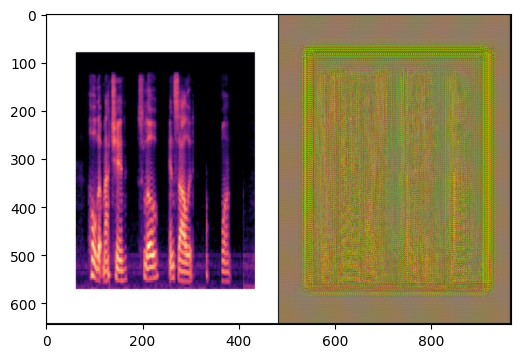

FID Score is:  358.7362060546875
FID Score is:  105.93917846679688
Epoch 2: Step 300: Generator (U-Net) loss: 1.7368730429808301, Discriminator loss: 0.2510511572162309


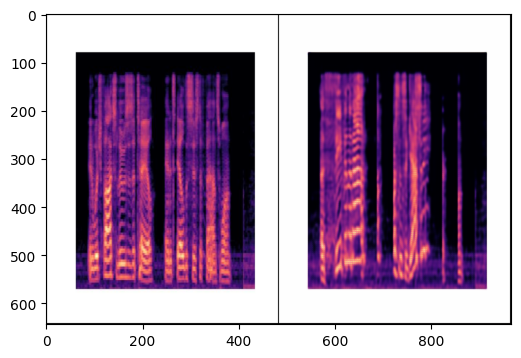

FID Score is:  115.15567016601562
FID Score is:  118.38838195800781
Epoch 4: Step 600: Generator (U-Net) loss: 1.122496159474056, Discriminator loss: 0.250730989476045


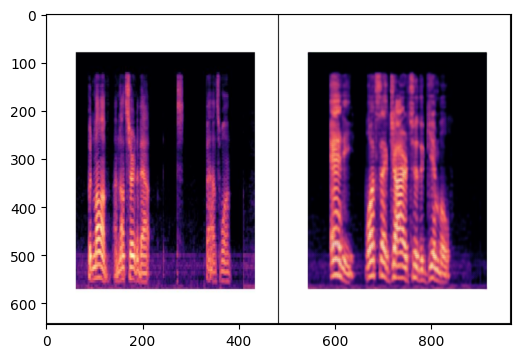

FID Score is:  119.16825866699219
FID Score is:  120.2119140625
Epoch 6: Step 900: Generator (U-Net) loss: 1.0180663031339643, Discriminator loss: 0.25050142005085957


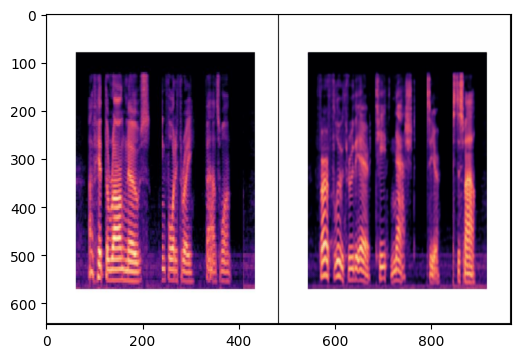

FID Score is:  115.8907470703125
FID Score is:  117.3250732421875
Epoch 8: Step 1200: Generator (U-Net) loss: 0.9603002943595256, Discriminator loss: 0.2504032787183921


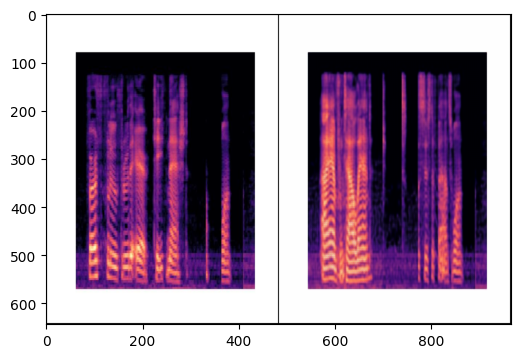

FID Score is:  113.35010528564453
FID Score is:  107.81608581542969
Epoch 10: Step 1500: Generator (U-Net) loss: 0.9167927682399746, Discriminator loss: 0.25028334433833765


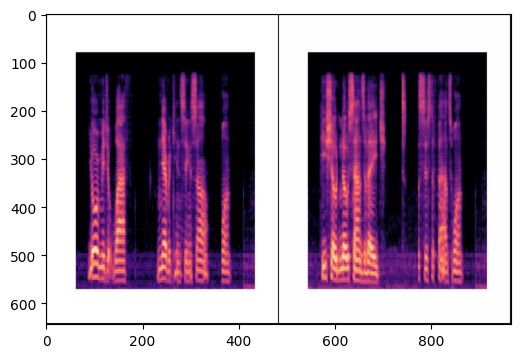

FID Score is:  102.95411682128906
FID Score is:  99.96961975097656
Epoch 12: Step 1800: Generator (U-Net) loss: 0.891249520381291, Discriminator loss: 0.25009744216998425


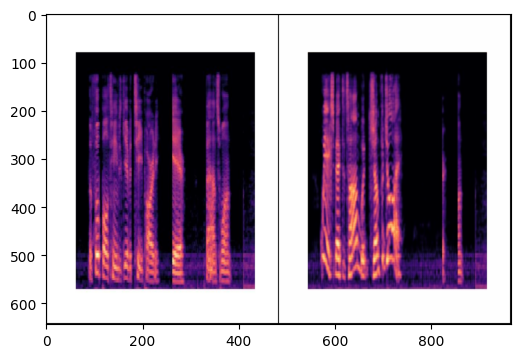

FID Score is:  96.33275604248047
FID Score is:  93.18647003173828
FID Score is:  94.87306213378906


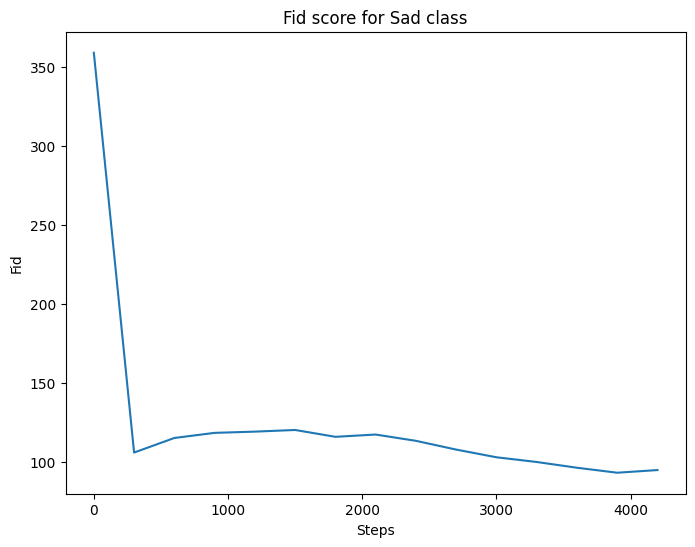

In [34]:
Sad_Gan = CycleGan(3,3,'Sad')
Sad_Fid = train(Sad_Gan)
Fid_plot(Sad_Fid,'Sad')
Sad_Gan.save_model('Gan_Results/Models',3500)

2
Epoch 0: Step 0: Generator (U-Net) loss: 0.06061052958170573, Discriminator loss: 0.002013707756996155


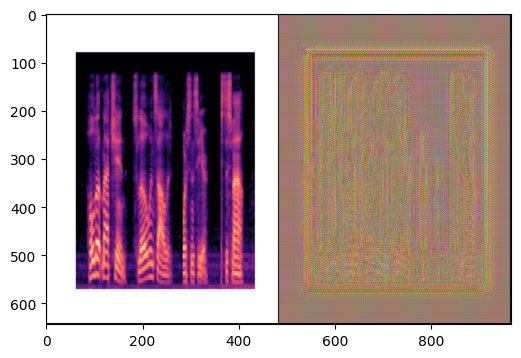

FID Score is:  791.6900634765625
FID Score is:  581.250244140625
Epoch 2: Step 300: Generator (U-Net) loss: 2.5373007078965513, Discriminator loss: 0.21692649347086734


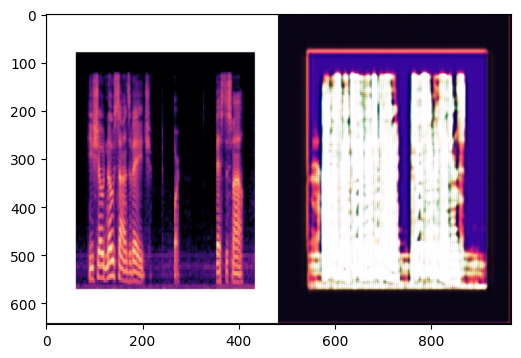

FID Score is:  504.66021728515625
FID Score is:  522.5706787109375
Epoch 4: Step 600: Generator (U-Net) loss: 1.8440235400199898, Discriminator loss: 0.21957804689804708


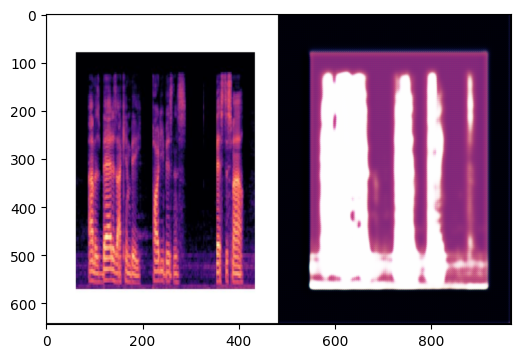

FID Score is:  498.8487243652344
FID Score is:  431.5410461425781
Epoch 6: Step 900: Generator (U-Net) loss: 2.005709735949834, Discriminator loss: 0.20308450952172305


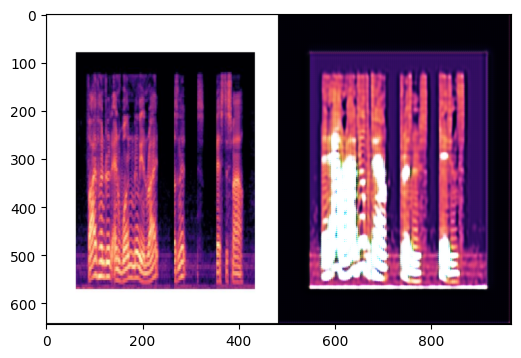

FID Score is:  405.396728515625
FID Score is:  413.14434814453125
Epoch 8: Step 1200: Generator (U-Net) loss: 1.784379184643428, Discriminator loss: 0.1981206753849984


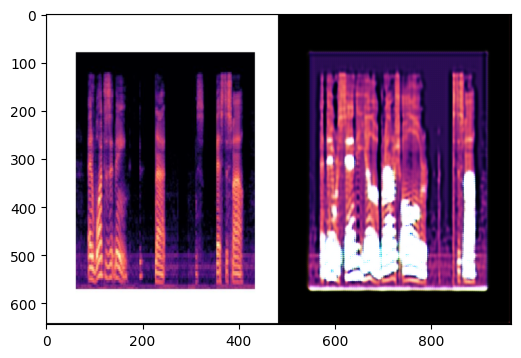

FID Score is:  396.0935363769531
FID Score is:  404.9886474609375
Epoch 10: Step 1500: Generator (U-Net) loss: 1.651579030752182, Discriminator loss: 0.1987912813822428


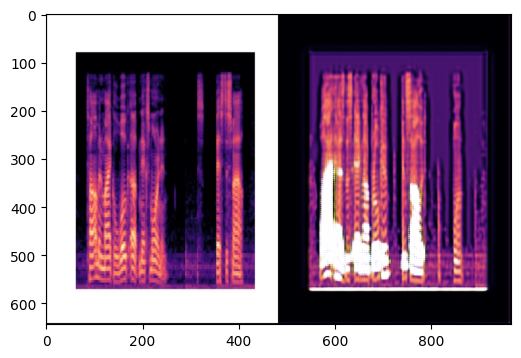

FID Score is:  390.8778076171875
FID Score is:  391.2034912109375
Epoch 12: Step 1800: Generator (U-Net) loss: 1.5836755386988306, Discriminator loss: 0.20013336583971977


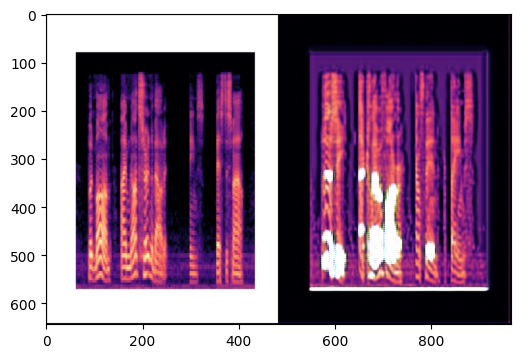

FID Score is:  398.1790771484375
FID Score is:  398.949951171875
FID Score is:  389.7889099121094


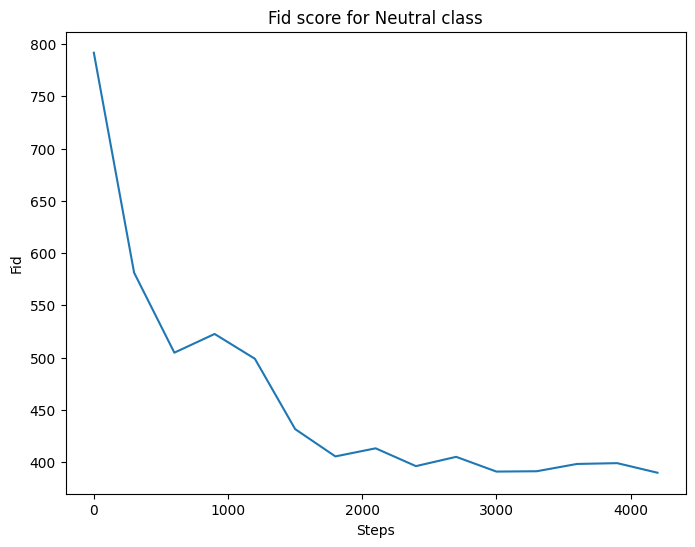

In [38]:
Neutral_Gan = CycleGan(3,3,'Neutral')
Neutral_Fid = train(Neutral_Gan)
Fid_plot(Neutral_Fid,'Neutral')
Neutral_Gan.save_model('Gan_Results/Models',3500)

0
Epoch 0: Step 0: Generator (U-Net) loss: 0.06286208470662435, Discriminator loss: 0.0015844017267227172


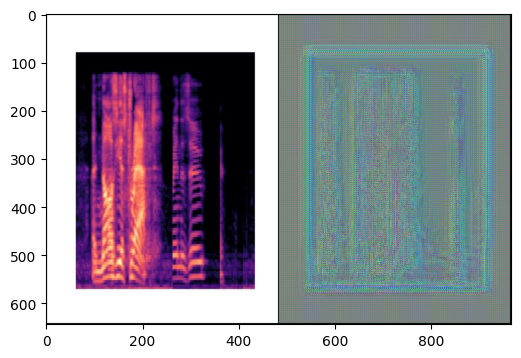

FID Score is:  614.5010375976562
FID Score is:  541.2695922851562
Epoch 2: Step 300: Generator (U-Net) loss: 2.257852637370428, Discriminator loss: 0.23015758474667875


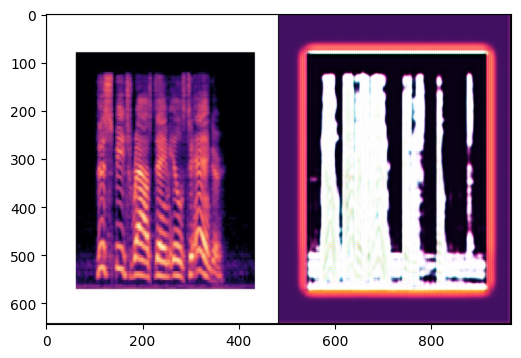

FID Score is:  462.002197265625
FID Score is:  431.13189697265625
Epoch 4: Step 600: Generator (U-Net) loss: 1.4917917342980704, Discriminator loss: 0.2252211804687976


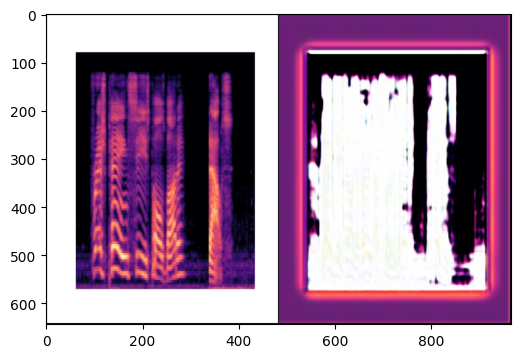

FID Score is:  423.12371826171875
FID Score is:  410.2809753417969
Epoch 6: Step 900: Generator (U-Net) loss: 1.4715613691012068, Discriminator loss: 0.21660621071855246


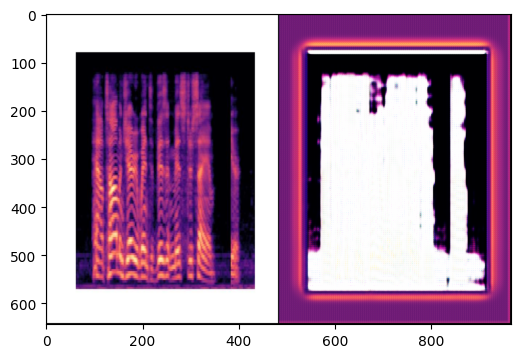

FID Score is:  405.73614501953125
FID Score is:  419.8484191894531
Epoch 8: Step 1200: Generator (U-Net) loss: 1.436614133119583, Discriminator loss: 0.21678840219974504


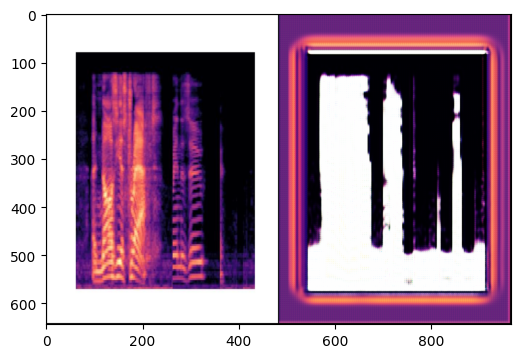

FID Score is:  398.5566711425781
FID Score is:  379.2132568359375
Epoch 10: Step 1500: Generator (U-Net) loss: 2.8613537768522885, Discriminator loss: 0.1913847892483074


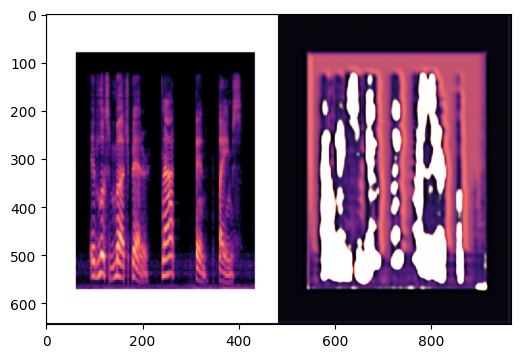

FID Score is:  369.6450500488281
FID Score is:  382.7249450683594
Epoch 12: Step 1800: Generator (U-Net) loss: 2.3623884463310256, Discriminator loss: 0.1804201130568981


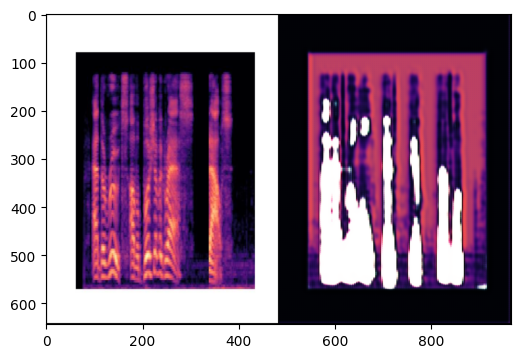

FID Score is:  374.8415222167969


In [ ]:
Angry_Gan = CycleGan(3,3,'Angry')
Angry_Fid = train(Angry_Gan)
Fid_plot(Angry_Fid,'Angry')
Angry_Gan.save_model('Gan_Results/Models',3500)

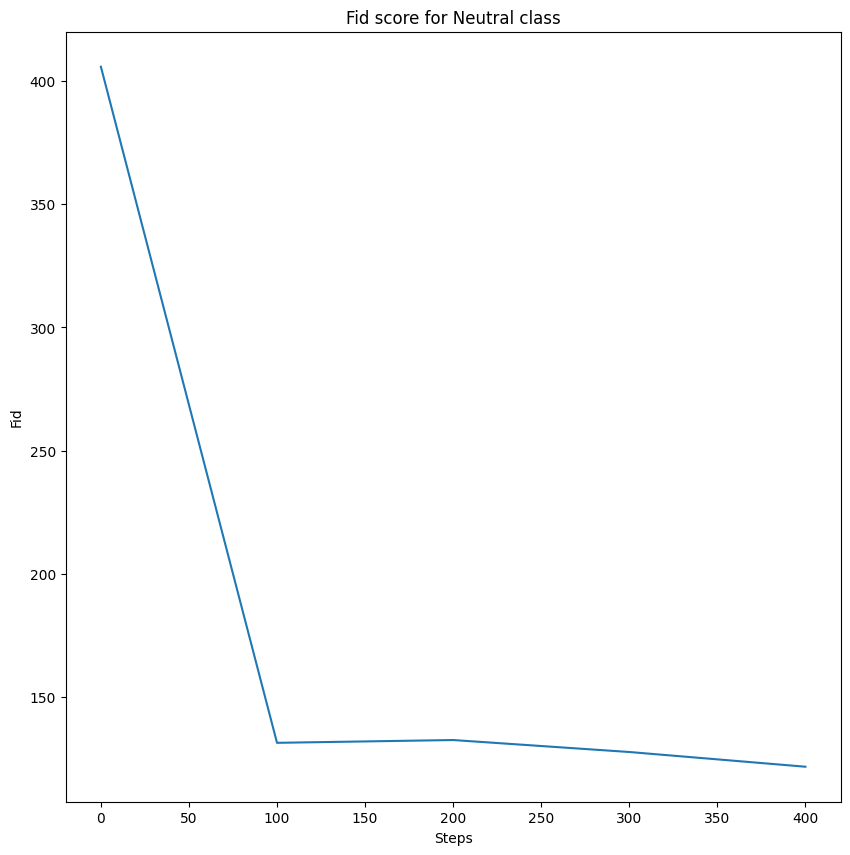

In [21]:
Fid_plot(Neutral_Fid,"Neutral")

4
Epoch 0: Step 0: Generator (U-Net) loss: 0.06128374735514323, Discriminator loss: 0.0018144261837005615


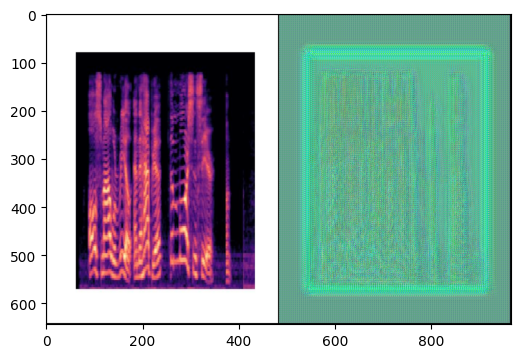

torch.Size([2048]) torch.Size([2048]) torch.Size([2048, 2048]) torch.Size([2048, 2048])
FID Score is:  3.1762917041778564


KeyboardInterrupt: 

In [16]:
Surprise_Gan = CycleGan(3,3,'Surprise')
Surprise_Fid = train(Surprise_Gan)
Fid_plot(Surprise_Fid,'Surprise')
#Surprise_Gan.save_model('Gan_Results/Models',3500)

In [1]:
def caesar_cipher(text, shift):
    encoded_text = ""
    for char in text:
        if char.isalpha():
            shifted = ord(char) + shift
            if char.islower():
                if shifted > ord('z'):
                    shifted -= 26
                elif shifted < ord('a'):
                    shifted += 26
            elif char.isupper():
                if shifted > ord('Z'):
                    shifted -= 26
                elif shifted < ord('A'):
                    shifted += 26
            encoded_text += chr(shifted)
        else:
            encoded_text += char
    return encoded_text

plaintext = "The Moonlight"
shift = 5

# Encode "hello" using Caesar cipher with a shift of 3
encoded_text = caesar_cipher(plaintext, shift)
print("Encoded text:", encoded_text)

Encoded text: Ymj Rttsqnlmy
